In [1]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from itertools import combinations
from pprint import pprint
import math
from typing import Literal

In [2]:
data_dir = Path('../data')

In [3]:
data_path = data_dir / 'Dataset3.csv'
df = pd.read_csv(data_path)
df

Temperature  Humidity  Rainfall        Soil     Crop Fertilizer
0          24.87     82.84    295.61      Clayey     rice        DAP
1          28.69     96.65    178.96    laterite  Coconut   Good NPK
2          20.27     81.64    270.44  silty clay     rice        MOP
3          25.07     95.02    192.90       sandy  Coconut       Urea
4          25.04     95.90    174.80     coastal  Coconut       Urea
..           ...       ...       ...         ...      ...        ...
290        26.07     96.70    143.53       sandy  Coconut        MOP
291        25.63     83.53    209.90  silty clay     rice        MOP
292        24.52     83.54    230.45      Clayey     rice        MOP
293        25.66     83.47    217.38      Clayey     rice        MOP
294        23.83     84.81    298.56  silty clay     rice        MOP

[295 rows x 6 columns]

# discretize the data

In [4]:
df

Temperature  Humidity  Rainfall        Soil     Crop Fertilizer
0          24.87     82.84    295.61      Clayey     rice        DAP
1          28.69     96.65    178.96    laterite  Coconut   Good NPK
2          20.27     81.64    270.44  silty clay     rice        MOP
3          25.07     95.02    192.90       sandy  Coconut       Urea
4          25.04     95.90    174.80     coastal  Coconut       Urea
..           ...       ...       ...         ...      ...        ...
290        26.07     96.70    143.53       sandy  Coconut        MOP
291        25.63     83.53    209.90  silty clay     rice        MOP
292        24.52     83.54    230.45      Clayey     rice        MOP
293        25.66     83.47    217.38      Clayey     rice        MOP
294        23.83     84.81    298.56  silty clay     rice        MOP

[295 rows x 6 columns]

In [5]:
df.describe()

Temperature    Humidity    Rainfall
count   295.000000  295.000000  295.000000
mean     25.522068   88.472271  205.330983
std       2.495289    6.550542   43.276280
min      20.050000   80.120000  131.090000
25%      23.810000   82.275000  172.480000
50%      25.760000   84.970000  202.940000
75%      27.170000   94.800000  231.560000
max      29.870000   99.980000  298.560000

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  295 non-null    float64
 1   Humidity     295 non-null    float64
 2   Rainfall     295 non-null    float64
 3   Soil         295 non-null    object 
 4   Crop         295 non-null    object 
 5   Fertilizer   295 non-null    object 
dtypes: float64(3), object(3)
memory usage: 14.0+ KB


In [7]:
# check if there is duplicated rows or missing values
df.duplicated().sum()

0

In [8]:
df.isna().sum()

Temperature    0
Humidity       0
Rainfall       0
Soil           0
Crop           0
Fertilizer     0
dtype: int64

we can see that there is no duplicated rows or missing values

In [9]:
discretize_column = 'Temperature'

In [10]:
def discretize_equal_width(input_df, column, *, n_bins=0):
    input_df = input_df.copy()
    sorted_data = input_df[column].sort_values()
    if n_bins == 0:
        n_bins =  int(1 + (10 / 3) * math.log10(len(sorted_data)))
    ranges = np.linspace(sorted_data.min(), sorted_data.max(), n_bins + 1)
    labels = [str(i) for i in range(1, n_bins + 1)]
    current_bin = 0
    class_column = []
    for i, row_temp in enumerate(sorted_data):
        if row_temp > ranges[current_bin + 1]:
            current_bin += 1
        class_column.append(labels[current_bin])
    input_df[f'class_{column}'] = class_column
    return input_df


In [11]:
df_width = discretize_equal_width(df, discretize_column)

In [12]:
def plot_classes(input_df, column=f'class_{discretize_column}'):
    sns.countplot(x=column, data=input_df)
    plt.xlabel('classes')
    plt.ylabel('Count')
    plt.title('class distribution')
    plt.show()

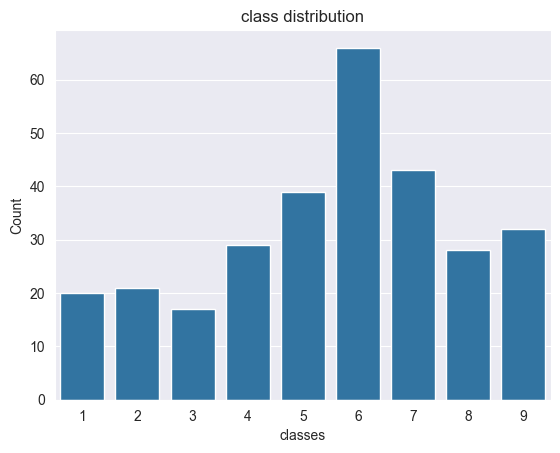

In [13]:
plot_classes(df_width)

In [14]:
def discretize_equal_freq(input_df, column, *, n_bins=0):
    input_df = input_df.copy()

    if n_bins == 0:
        n_bins = int(1 + (10 / 3) * math.log10(len(input_df[column])))

    sorted_values = sorted(input_df[column])

    bin_edges = [sorted_values[i * len(sorted_values) // n_bins] for i in range(n_bins)]
    bin_edges.append(sorted_values[-1])  # Include the maximum value
    labels = [str(i) for i in range(1, n_bins + 1)]

    discrete_column = []
    current_bin = 0

    for i, value in enumerate(sorted_values):
        if value > bin_edges[current_bin + 1]:
            current_bin += 1
        discrete_column.append(labels[current_bin])

    input_df[f'class_{column}'] = discrete_column

    return input_df

In [15]:
df_freq = discretize_equal_freq(df, discretize_column)

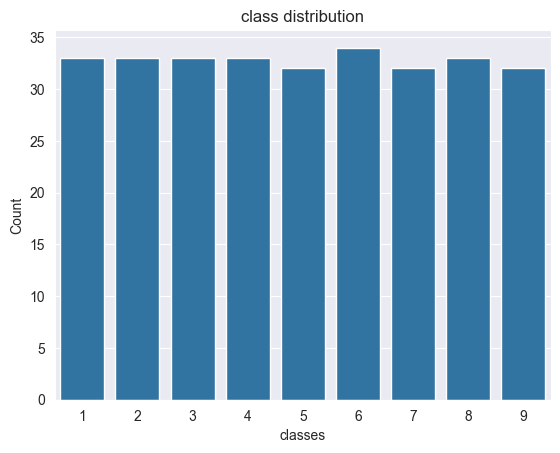

In [16]:
plot_classes(df_freq)

# Apriori and association rules

In [17]:
def get_grouped_df(input_df, columns=None):
    if columns is None:
        columns = ['Soil', 'Fertilizer', 'Crop']
    return input_df.groupby(columns).agg({
        f'class_{discretize_column}': set,
        }).rename(columns={f'class_{discretize_column}': 'Items'})
grouped_df = get_grouped_df(df_width)
grouped_df.to_csv(data_dir / 'part3_grouped_df.csv')
grouped_df

Items
Soil       Fertilizer Crop                             
Clayey     DAP        rice           {3, 2, 1, 6, 8, 5}
           Good NPK   rice                          {6}
           MOP        rice              {3, 2, 7, 4, 9}
           Urea       rice           {3, 7, 1, 4, 6, 5}
alluvial   DAP        Coconut                    {7, 1}
           MOP        Coconut              {8, 9, 2, 7}
           Urea       Coconut           {3, 2, 1, 4, 5}
clay loam  DAP        rice                 {2, 7, 5, 1}
           Good NPK   rice                    {3, 5, 4}
           MOP        rice                    {9, 2, 7}
           Urea       rice              {3, 2, 1, 4, 5}
coastal    DAP        Coconut           {3, 7, 4, 6, 8}
           Good NPK   Coconut              {6, 2, 5, 4}
           MOP        Coconut           {9, 7, 6, 8, 5}
           Urea       Coconut        {3, 2, 1, 4, 6, 5}
laterite   DAP        Coconut              {2, 7, 1, 4}
           Good NPK   Coconut                 {3, 5, 1}
           MOP        Coconut                 {8, 9, 7}
           Urea       Coconut           {3, 2, 1, 4, 5}
sandy      DAP        Coconut           {3, 7, 6, 8, 5}
           Good NPK   Coconut        {3, 2, 1, 4, 6, 5}
           MOP        Coconut           {9, 7, 6, 8, 5}
           Urea       Coconut        {3, 2, 1, 4, 6, 5}
silty clay DAP        rice     {3, 2, 7, 1, 4, 6, 8, 5}
           Good NPK   rice                          {5}
           MOP        rice                 {9, 7, 1, 4}
           Urea       rice        {3, 2, 7, 1, 4, 6, 5}

In [18]:
class Apriori:
    Metric = Literal['confidence', 'cosine', 'lift', 'all_confidence', 'max_confidence', 'jaccard', 'kulczynski']
    def __init__(self, min_support, min_confidence):
        self.df = None
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.frequent_itemsets = []

    def set_params(self, *, min_support, min_confidence):
        self.min_support = min_support if min_support else self.min_support
        self.min_confidence = min_confidence if min_confidence else self.min_confidence

    def fit(self, input_df):
        self.frequent_itemsets = []
        self.df = input_df
        self._get_frequent_itemsets()
        self._get_rules()

    def _get_frequent_itemsets(self):
        self._get_frequent_1_itemsets()
        k = 2
        while True:
            frequent_itemsets = self._get_frequent_k_itemsets(k)
            if not frequent_itemsets:
                break
            self.frequent_itemsets.append(frequent_itemsets)
            k += 1

    def _get_frequent_1_itemsets(self):
        self.item_counts = Counter()
        for itemset in self.df['Items']:
            self.item_counts.update(itemset)

        n = len(self.df)
        self.frequent_itemsets.append([
            (frozenset([item]), support / n)
            for item, support in self.item_counts.items()
            if support / n >= self.min_support
        ])

    def _get_frequent_k_itemsets(self, k):
        itemsets = self.frequent_itemsets[k - 2]
        frequent_itemsets = []
        for itemset1, support1 in itemsets:
            for itemset2, support2 in itemsets:
                if itemset1 == itemset2:
                    continue
                union = itemset1 | itemset2
                if len(union) != k:
                    continue
                if union in (itemset for itemset, _ in frequent_itemsets):
                    continue
                support = self._get_support(union)
                if support >= self.min_support:
                    frequent_itemsets.append((union, support))
        return frequent_itemsets

    def _get_rules(self):
        self.rules = []
        for itemsets in self.frequent_itemsets:
            for itemset, support in itemsets:
                if len(itemset) < 2:
                    continue
                for antecedent in self._get_antecedents(itemset):
                    antecedent_support = self._get_support(antecedent)
                    if support / antecedent_support >= self.min_confidence:
                        self.rules.append((antecedent, itemset - antecedent, support / antecedent_support))
        return self.rules

    @staticmethod
    def _get_antecedents(itemset: set) -> list[tuple]:
        antecedents = []
        for i in range(1, len(itemset)):
            current_antecedents = combinations(itemset, i)
            current_antecedents = {frozenset(antecedent) for antecedent in current_antecedents}
            antecedents.extend(current_antecedents)
        return antecedents

    def _get_support(self, itemset):
        return sum(1 for itemset2 in self.df['Items'] if itemset.issubset(itemset2)) / len(self.df)

    def _get_cosines(self):
        self.cosines = []
        for itemset1, consequent, confidence in self.rules:
            cosine = self._get_support(itemset1 | consequent) / math.sqrt(self._get_support(itemset1) * self._get_support(consequent))
            self.cosines.append((itemset1, consequent, cosine))
        return self.cosines

    def _get_lifts(self):
        self.lifts = []
        for itemset1, consequent, confidence in self.rules:
            lift = confidence / self._get_support(consequent)
            self.lifts.append((itemset1, consequent, lift))
        return self.lifts


    def _get_jaccard(self):
        self.jaccard = []
        for itemset1, consequent, confidence in self.rules:
            jaccard = self._get_support(itemset1 | consequent) / (self._get_support(itemset1) + self._get_support(consequent) - self._get_support(itemset1 | consequent))
            self.jaccard.append((itemset1, consequent, jaccard))
        return self.jaccard

    def _get_kulczynski(self):
        self.kulczynski = []
        for itemset1, consequent, confidence in self.rules:
            join_support = self._get_support(itemset1 | consequent)
            kulczynski = ((join_support / self._get_support(itemset1)) + (join_support / self._get_support(consequent))) / 2
            self.kulczynski.append((itemset1, consequent, kulczynski))
        return self.kulczynski

    def _get_max_confidence(self):
        self.max_confidence = []
        for itemset1, consequent, confidence in self.rules:
            join_support = self._get_support(itemset1 | consequent)
            max_confidence = max(self._get_support(itemset1) / join_support, self._get_support(consequent) / join_support)
            self.max_confidence.append((itemset1, consequent, max_confidence))
        return self.max_confidence

    def _get_all_confidence(self):
        self.all_confidence = []
        for itemset1, consequent, confidence in self.rules:
            all_confidence = self._get_support(itemset1 | consequent) / max(self._get_support(itemset1), self._get_support(consequent))
            self.all_confidence.append((itemset1, consequent, all_confidence))
        return self.all_confidence

    def get_strong_rules(self, *, metric: Metric = 'confidence', n_rules: int = 10):
        sorting_functions = {
            'confidence': lambda: sorted(self.rules, key=lambda x: x[2], reverse=True),
            'cosine': lambda: sorted(self._get_cosines(), key=lambda x: x[2], reverse=True),
            'lift': lambda: sorted(self._get_lifts(), key=lambda x: x[2], reverse=True),
            'all_confidence': lambda: sorted(self._get_all_confidence(), key=lambda x: x[2], reverse=True),
            'jaccard': lambda: sorted(self._get_jaccard(), key=lambda x: x[2], reverse=True),
            'kulczynski': lambda: sorted(self._get_kulczynski(), key=lambda x: x[2], reverse=True),
            'max_confidence': lambda: sorted(self._get_max_confidence(), key=lambda x: x[2], reverse=True),
        }

        if metric in sorting_functions:
            return sorting_functions[metric]()[:n_rules]
        else:
            raise ValueError(f'metric should be one of {", ".join(sorting_functions.keys())}')


    def predict(self, items: list[str], *, metric: Metric = 'confidence'):
        prediction_functions = {
            'confidence': self._predict_confidence,
            'cosine': self._predict_cosine,
            'lift': self._predict_lift,
            'all_confidence': self._predict_all_confidence,
            'jaccard': self._predict_jaccard,
            'kulczynski': self._predict_kulczynski,
            'max_confidence': self._predict_max_confidence,
        }

        if metric in prediction_functions:
            return prediction_functions[metric](items)
        else:
            raise ValueError(f'metric should be one of {", ".join(prediction_functions.keys())}')

    def _predict_confidence(self, items: list[str]):
        items = set(items)
        predictions = []
        for itemset1, consequent, confidence in self.rules:
            if itemset1 == items:
                predictions.append((consequent, confidence))
        return sorted(predictions, key=lambda x: x[1], reverse=True)


    def _predict_cosine(self, items: list[str]):
        items = set(items)
        predictions = []
        for itemset1, consequent, cosine in self._get_cosines():
            if itemset1 == items:
                predictions.append((consequent, cosine))
        return sorted(predictions, key=lambda x: x[1], reverse=True)


    def _predict_lift(self, items: list[str]):
        items = set(items)
        predictions = []
        for itemset1, consequent, lift in self._get_lifts():
            if itemset1 == items:
                predictions.append((consequent, lift))
        return sorted(predictions, key=lambda x: x[1], reverse=True)


    def _predict_all_confidence(self, items: list[str]):
        items = set(items)
        predictions = []
        for itemset1, consequent, all_confidence in self._get_all_confidence():
            if itemset1 == items:
                predictions.append((consequent, all_confidence))
        return sorted(predictions, key=lambda x: x[1], reverse=True)


    def _predict_jaccard(self, items: list[str]):
        items = set(items)
        predictions = []
        for itemset1, consequent, jaccard in self._get_jaccard():
            if itemset1 == items:
                predictions.append((consequent, jaccard))
        return sorted(predictions, key=lambda x: x[1], reverse=True)


    def _predict_kulczynski(self, items: list[str]):
        items = set(items)
        predictions = []
        for itemset1, consequent, kulczynski in self._get_kulczynski():
            if itemset1 == items:
                predictions.append((consequent, kulczynski))
        return sorted(predictions, key=lambda x: x[1], reverse=True)


    def _predict_max_confidence(self, items: list[str]):
        items = set(items)
        predictions = []
        for itemset1, consequent, max_confidence in self._get_max_confidence():
            if itemset1 == items:
                predictions.append((consequent, max_confidence))
        return sorted(predictions, key=lambda x: x[1], reverse=True)


In [19]:
apriori = Apriori(min_support=0.4, min_confidence=0.8)

In [20]:
apriori.fit(grouped_df)

In [21]:
pprint(apriori.frequent_itemsets)

[[(frozenset({'3'}), 0.5555555555555556),
  (frozenset({'2'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'6'}), 0.48148148148148145),
  (frozenset({'5'}), 0.6666666666666666),
  (frozenset({'7'}), 0.5555555555555556),
  (frozenset({'4'}), 0.5555555555555556)],
 [(frozenset({'3', '1'}), 0.4074074074074074),
  (frozenset({'3', '5'}), 0.48148148148148145),
  (frozenset({'3', '4'}), 0.4444444444444444),
  (frozenset({'2', '1'}), 0.4074074074074074),
  (frozenset({'2', '5'}), 0.4074074074074074),
  (frozenset({'2', '4'}), 0.4074074074074074),
  (frozenset({'5', '1'}), 0.4444444444444444),
  (frozenset({'1', '4'}), 0.4074074074074074),
  (frozenset({'6', '5'}), 0.4074074074074074),
  (frozenset({'5', '4'}), 0.4074074074074074)],
 [(frozenset({'3', '5', '1'}), 0.4074074074074074)]]


In [22]:
pprint(apriori.rules)

[(frozenset({'3'}), frozenset({'5'}), 0.8666666666666666),
 (frozenset({'6'}), frozenset({'5'}), 0.8461538461538461),
 (frozenset({'3', '5'}), frozenset({'1'}), 0.8461538461538461),
 (frozenset({'3', '1'}), frozenset({'5'}), 1.0),
 (frozenset({'5', '1'}), frozenset({'3'}), 0.9166666666666666)]


In [23]:
metrics = ['confidence', 'cosine', 'lift', 'all_confidence', 'jaccard', 'kulczynski', 'max_confidence']
for metric in metrics:
    print(f'{metric=}')
    pprint(apriori.get_strong_rules(metric=metric, n_rules=2))
    print('------------------')

metric='confidence'
[(frozenset({'3', '1'}), frozenset({'5'}), 1.0),
 (frozenset({'5', '1'}), frozenset({'3'}), 0.9166666666666666)]
------------------
metric='cosine'
[(frozenset({'5', '1'}), frozenset({'3'}), 0.8198915917499229),
 (frozenset({'3'}), frozenset({'5'}), 0.7911548052852398)]
------------------
metric='lift'
[(frozenset({'5', '1'}), frozenset({'3'}), 1.65),
 (frozenset({'3', '5'}), frozenset({'1'}), 1.523076923076923)]
------------------
metric='all_confidence'
[(frozenset({'3', '5'}), frozenset({'1'}), 0.7333333333333333),
 (frozenset({'5', '1'}), frozenset({'3'}), 0.7333333333333333)]
------------------
metric='jaccard'
[(frozenset({'5', '1'}), frozenset({'3'}), 0.6875),
 (frozenset({'3'}), frozenset({'5'}), 0.6499999999999998)]
------------------
metric='kulczynski'
[(frozenset({'5', '1'}), frozenset({'3'}), 0.825),
 (frozenset({'3', '1'}), frozenset({'5'}), 0.8055555555555556)]
------------------
metric='max_confidence'
[(frozenset({'6'}), frozenset({'5'}), 1.63636363

# Apriori Tests with different support and confidence

In [24]:
apriori.set_params(min_support=0.4, min_confidence=0.1)
apriori.fit(grouped_df)
print('Itemsets :')
pprint(apriori.frequent_itemsets)
print('------------------ \n Rules :')
pprint(apriori.rules)

Itemsets :
[[(frozenset({'3'}), 0.5555555555555556),
  (frozenset({'2'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'6'}), 0.48148148148148145),
  (frozenset({'5'}), 0.6666666666666666),
  (frozenset({'7'}), 0.5555555555555556),
  (frozenset({'4'}), 0.5555555555555556)],
 [(frozenset({'3', '1'}), 0.4074074074074074),
  (frozenset({'3', '5'}), 0.48148148148148145),
  (frozenset({'3', '4'}), 0.4444444444444444),
  (frozenset({'2', '1'}), 0.4074074074074074),
  (frozenset({'2', '5'}), 0.4074074074074074),
  (frozenset({'2', '4'}), 0.4074074074074074),
  (frozenset({'5', '1'}), 0.4444444444444444),
  (frozenset({'1', '4'}), 0.4074074074074074),
  (frozenset({'6', '5'}), 0.4074074074074074),
  (frozenset({'5', '4'}), 0.4074074074074074)],
 [(frozenset({'3', '5', '1'}), 0.4074074074074074)]]
------------------ 
 Rules :
[(frozenset({'3'}), frozenset({'1'}), 0.7333333333333333),
 (frozenset({'1'}), frozenset({'3'}), 0.7333333333333333),
 (frozenset({'3'}), f

In [25]:
apriori.set_params(min_support=0.5, min_confidence=0.1)
apriori.fit(grouped_df)
print('Itemsets :')
pprint(apriori.frequent_itemsets)
print('------------------ \n Rules :')
pprint(apriori.rules)

Itemsets :
[[(frozenset({'3'}), 0.5555555555555556),
  (frozenset({'2'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'5'}), 0.6666666666666666),
  (frozenset({'7'}), 0.5555555555555556),
  (frozenset({'4'}), 0.5555555555555556)]]
------------------ 
 Rules :
[]


In [26]:
apriori.set_params(min_support=0.3, min_confidence=0.6)
apriori.fit(grouped_df)
print('Itemsets :')
pprint(apriori.frequent_itemsets)
print('------------------ \n Rules :')
pprint(apriori.rules)

Itemsets :
[[(frozenset({'3'}), 0.5555555555555556),
  (frozenset({'2'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'6'}), 0.48148148148148145),
  (frozenset({'5'}), 0.6666666666666666),
  (frozenset({'7'}), 0.5555555555555556),
  (frozenset({'4'}), 0.5555555555555556)],
 [(frozenset({'3', '2'}), 0.37037037037037035),
  (frozenset({'3', '1'}), 0.4074074074074074),
  (frozenset({'6', '3'}), 0.3333333333333333),
  (frozenset({'3', '5'}), 0.48148148148148145),
  (frozenset({'3', '4'}), 0.4444444444444444),
  (frozenset({'2', '1'}), 0.4074074074074074),
  (frozenset({'2', '5'}), 0.4074074074074074),
  (frozenset({'2', '4'}), 0.4074074074074074),
  (frozenset({'5', '1'}), 0.4444444444444444),
  (frozenset({'1', '4'}), 0.4074074074074074),
  (frozenset({'6', '5'}), 0.4074074074074074),
  (frozenset({'5', '4'}), 0.4074074074074074)],
 [(frozenset({'3', '1', '2'}), 0.3333333333333333),
  (frozenset({'3', '5', '2'}), 0.3333333333333333),
  (frozenset({'3', '4'

In [27]:
apriori.set_params(min_support=0.4, min_confidence=0.8)
apriori.fit(grouped_df)
print('Itemsets :')
pprint(apriori.frequent_itemsets)
print('------------------ \n Rules :')
pprint(apriori.rules)

Itemsets :
[[(frozenset({'3'}), 0.5555555555555556),
  (frozenset({'2'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'6'}), 0.48148148148148145),
  (frozenset({'5'}), 0.6666666666666666),
  (frozenset({'7'}), 0.5555555555555556),
  (frozenset({'4'}), 0.5555555555555556)],
 [(frozenset({'3', '1'}), 0.4074074074074074),
  (frozenset({'3', '5'}), 0.48148148148148145),
  (frozenset({'3', '4'}), 0.4444444444444444),
  (frozenset({'2', '1'}), 0.4074074074074074),
  (frozenset({'2', '5'}), 0.4074074074074074),
  (frozenset({'2', '4'}), 0.4074074074074074),
  (frozenset({'5', '1'}), 0.4444444444444444),
  (frozenset({'1', '4'}), 0.4074074074074074),
  (frozenset({'6', '5'}), 0.4074074074074074),
  (frozenset({'5', '4'}), 0.4074074074074074)],
 [(frozenset({'3', '5', '1'}), 0.4074074074074074)]]
------------------ 
 Rules :
[(frozenset({'3'}), frozenset({'5'}), 0.8666666666666666),
 (frozenset({'6'}), frozenset({'5'}), 0.8461538461538461),
 (frozenset({'3', '5'

In [28]:
apriori.set_params(min_support=0.4, min_confidence=0.5)
apriori.fit(grouped_df)
print('Itemsets :')
pprint(apriori.frequent_itemsets)
print('------------------ \n Rules :')
pprint(apriori.rules)

Itemsets :
[[(frozenset({'3'}), 0.5555555555555556),
  (frozenset({'2'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'6'}), 0.48148148148148145),
  (frozenset({'5'}), 0.6666666666666666),
  (frozenset({'7'}), 0.5555555555555556),
  (frozenset({'4'}), 0.5555555555555556)],
 [(frozenset({'3', '1'}), 0.4074074074074074),
  (frozenset({'3', '5'}), 0.48148148148148145),
  (frozenset({'3', '4'}), 0.4444444444444444),
  (frozenset({'2', '1'}), 0.4074074074074074),
  (frozenset({'2', '5'}), 0.4074074074074074),
  (frozenset({'2', '4'}), 0.4074074074074074),
  (frozenset({'5', '1'}), 0.4444444444444444),
  (frozenset({'1', '4'}), 0.4074074074074074),
  (frozenset({'6', '5'}), 0.4074074074074074),
  (frozenset({'5', '4'}), 0.4074074074074074)],
 [(frozenset({'3', '5', '1'}), 0.4074074074074074)]]
------------------ 
 Rules :
[(frozenset({'3'}), frozenset({'1'}), 0.7333333333333333),
 (frozenset({'1'}), frozenset({'3'}), 0.7333333333333333),
 (frozenset({'3'}), f

# Apriori Predictions

In [29]:
apriori.predict(['1'], metric='confidence')

[(frozenset({'5'}), 0.7999999999999999),
 (frozenset({'3'}), 0.7333333333333333),
 (frozenset({'2'}), 0.7333333333333333),
 (frozenset({'4'}), 0.7333333333333333),
 (frozenset({'3', '5'}), 0.7333333333333333)]

# Check if apriori is working

In [30]:
items_A = ['1']
items_B = ['5', '3']

A_union_B = sum(grouped_df['Items'].apply(lambda x: all(item in x for item in items_A + items_B)))
A = sum(grouped_df['Items'].apply(lambda x: all(item in x for item in items_A)))
B = sum(grouped_df['Items'].apply(lambda x: all(item in x for item in items_B)))

union_support = A_union_B / len(grouped_df)
query_confidence = A_union_B / A

print(f'{items_A=} {items_B=} {union_support=} {query_confidence=}')

items_A=['1'] items_B=['5', '3'] union_support=0.4074074074074074 query_confidence=0.7333333333333333


- we can see that the result is the same as the confidence of the rule